# Survey and experiment analysis


Data were openly published in a Github repository: https://github.com/aberke/fingerprinting-study

In [ ]:
from datetime import datetime

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.formula.api as smf

# view all the columns
pd.set_option('display.max_columns', None)

survey_experiment_fpath = 'https://raw.githubusercontent.com/aberke/fingerprinting-study/master/data/survey-experiment-data.csv'

## Prepare survey data


Read in the fields data.

In [ ]:
# show the fields
fields_fpath = 'https://raw.githubusercontent.com/aberke/fingerprinting-study/master/data/fields.csv'
fields_df = pd.read_csv(fields_fpath).set_index('Column')
fields_df

,Text
Column,
ResponseId,Response ID
Duration (in seconds),Duration (in seconds)
showdata,showdata
Q-demos-age,What is your age group?
Q-demos-gender,How do you describe yourself?
Q-demos-hispanic,"Are you of Spanish, Hispanic, or Latino origin?"
Q-demos-race,Choose one or more races that you consider you...
Q-demos-income,What was your total household income before ta...
Q-demos-state,"50 States, D.C. and Puerto Rico"


Read in and transform survey data

In [ ]:
# read survey data
survey_df = pd.read_csv(survey_experiment_fpath)
N = len(survey_df)
print('Read in %s rows of data' % N)
# set boolean indicating share/decline (1/0)
survey_df['share'] = survey_df['Q-share-browser-data'].apply(lambda x: 1 if x.lower().startswith('consent') else 0)
# code showdata as a 1/0 boolean corresponding to true/false
survey_df['showdata'] = survey_df['showdata'].map({True: 1, False: 0})
survey_df.head(3)

Read in 12461 rows of data


,ResponseId,Duration (in seconds),showdata,Q-demos-age,Q-demos-gender,Q-demos-hispanic,Q-demos-race,Q-demos-income,Q-demos-state,Q-share-browser-data,Q-perceptions-1,Q-perceptions-2,share
0,R_101oyAyq2wwTyyi,115,0,55 - 64 years,Female,No,Black or African American,Prefer not to say,Washington,Decline,Strongly disagree,Strongly agree,0
1,R_1037uEjkfmk786A,47,0,35 - 44 years,Male,No,Asian,"$75,000 - $99,999",California,Decline,Somewhat agree,Strongly agree,0
2,R_107DpGEXCf0M8mM,58,1,45 - 54 years,Male,No,White or Caucasian,"$75,000 - $99,999",Ohio,Consent to share,Strongly agree,Neutral,1


#### Data transformations

Fix up some annoying strings

Aggregate variables to correspond to how we report on demographics (e.g. aggregate race categories)

In [ ]:
# Escape the $. It might look like Google colab already handles this but patsy (formula interpreter) does not.
survey_df['Q-demos-income'] = survey_df['Q-demos-income'].map({
    'Less than $25,000': 'Less than \$25,000',
    '$25,000 - $49,999': '\$25,000 - \$49,999',
    '$50,000 - $74,999': '\$50,000 - \$74,999',
    '$75,000 - $99,999': '\$75,000 - \$99,999',
    '$100,000 - $149,999':'\$100,000 - \$149,999',
    '$150,000 or more': '\$150,000 or more',
    'Prefer not to say': 'Prefer not to say'
})

In [ ]:
# rename some variables so that they work in regression formulas ('Q-*' breaks things)
survey_df['age'] = survey_df['Q-demos-age']   # Age group, 18+; Aggregate to smaller groups?
survey_df['gender'] = survey_df['Q-demos-gender'] # Aggregate this to male vs non-male?
survey_df['income'] = survey_df['Q-demos-income'] # Aggregate to smaller groups? Remove prefer not to say?

Transforms for race and ethnicity
- Map race to shorter names and aggregate other and mixed to 'Other or mixed'
- Set Hispanic as a 0/1 boolean

In [ ]:
survey_df['hispanic'] = survey_df['Q-demos-hispanic'].map({'Yes': 1, 'No': 0})

In [ ]:
# map race to shorter names and aggregate other and mixed to 'Other or mixed'
race_names_map = {
    'White or Caucasian': 'White',
    'Black or African American': 'Black',
    'Native Hawaiian or Other Pacific Islander':'Native Hawaiian or Other Pacific Islander',
    'American Indian/Native American or Alaska Native': 'American Indian/Alaska Native',
}
def map_race(r):
    if ('other' in r.lower() or len(r.split(',')) > 1):
        return 'Other or mixed'
    if r in race_names_map:
        return race_names_map[r]
    return r

survey_df['race'] = survey_df['Q-demos-race'].apply(map_race)
# survey_df.head(3)

In [ ]:
# Fix up some annoying values.
S1 = 'Q-perceptions-1'
S2 = 'Q-perceptions-2'
# Trim whitespace
survey_df[S1] = survey_df[S1].apply(str.strip)
survey_df[S2] = survey_df[S2].apply(str.strip)
# survey_df.head(3)

## Share vs not share

What was the share rate? How did this differ by whether someone was in the showdata true/false experiment arm?

Show this in a table.

Show this in a plot

In [ ]:
# Overall share N and share rate.
print('%s/%s = %0.3f participants shared data' % (
    survey_df['share'].sum(), len(survey_df), survey_df['share'].sum()/len(survey_df)))
share_agg_df = survey_df.groupby('showdata')['share'].agg(
    ['count','mean']
).rename(columns={'count':'N', 'mean': 'share rate'}).rename({0:'False',1:'True'}).round(3)
share_agg_df

8400/12461 = 0.674 participants shared data


,N,share rate
showdata,,
False,6204,0.691
True,6257,0.658


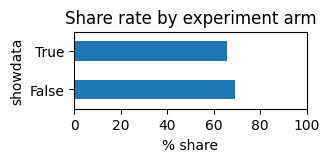

In [ ]:
fig, ax = plt.subplots(figsize=(3,1))
_ = (100*share_agg_df['share rate']).plot(kind='barh', ax=ax)
ax.set_xlabel('% share')
ax.set_xlim(0, 100)
_ = ax.set_title('Share rate by experiment arm')

### Diagnostic question: Did participants take longer to complete the survey when shown their data?

Can we detect a longer survey duration and infer they actually did look at their data?

First check the distribution of duration values. Check if normal -- if so then can use a t-test.

Compute mean duration for overall, showdata=true, showdata=false.

Observations:
- the showdata:true group has a longer tail, given that SOME participants did take longer vs showdata:false
- this also results in a slightly larger variance for showdata:true (relevant for t-test).

Distribution overall


count    12461.000000
mean        87.983388
std        104.425187
min         19.000000
25%         49.000000
50%         66.000000
75%         94.000000
max       5441.000000
Name: Duration (in seconds), dtype: float64

Distribution for showdata:true


count    6257.000000
mean       95.270737
std       103.635111
min        19.000000
25%        54.000000
50%        72.000000
75%       102.000000
max      2521.000000
Name: Duration (in seconds), dtype: float64

Distribution for showdata:false


count    6204.000000
mean       80.633785
std       104.711855
min        20.000000
25%        45.000000
50%        60.000000
75%        85.000000
max      5441.000000
Name: Duration (in seconds), dtype: float64

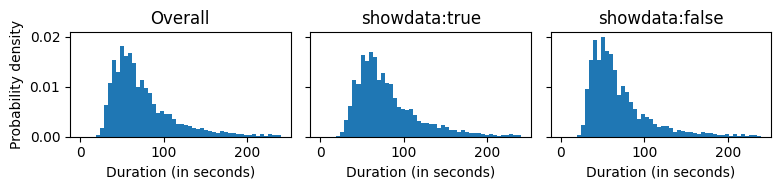

In [ ]:
durations_overall = survey_df['Duration (in seconds)']
durations_showdata_true = survey_df[survey_df['showdata']==1]['Duration (in seconds)']
durations_showdata_false = survey_df[survey_df['showdata']==0]['Duration (in seconds)']

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(8, 2), sharey=True)#, dpi=300)
_ = ax0.hist(durations_overall, bins=50, density=True, range=(0, 60*4))
ax0.set_title('Overall')
ax0.set_ylabel('Probability density')
_ = ax1.hist(durations_showdata_true, bins=50, density=True, range=(0, 60*4))
ax1.set_title('showdata:true')
_ = ax2.hist(durations_showdata_false, bins=50, density=True, range=(0, 60*4))
ax2.set_title('showdata:false')
for ax in [ax0, ax1, ax2]:
    ax.set_xlabel('Duration (in seconds)')
plt.tight_layout()

print('Distribution overall')
display(durations_overall.describe())
print('Distribution for showdata:true')
display(durations_showdata_true.describe())
print('Distribution for showdata:false')
display(durations_showdata_false.describe())

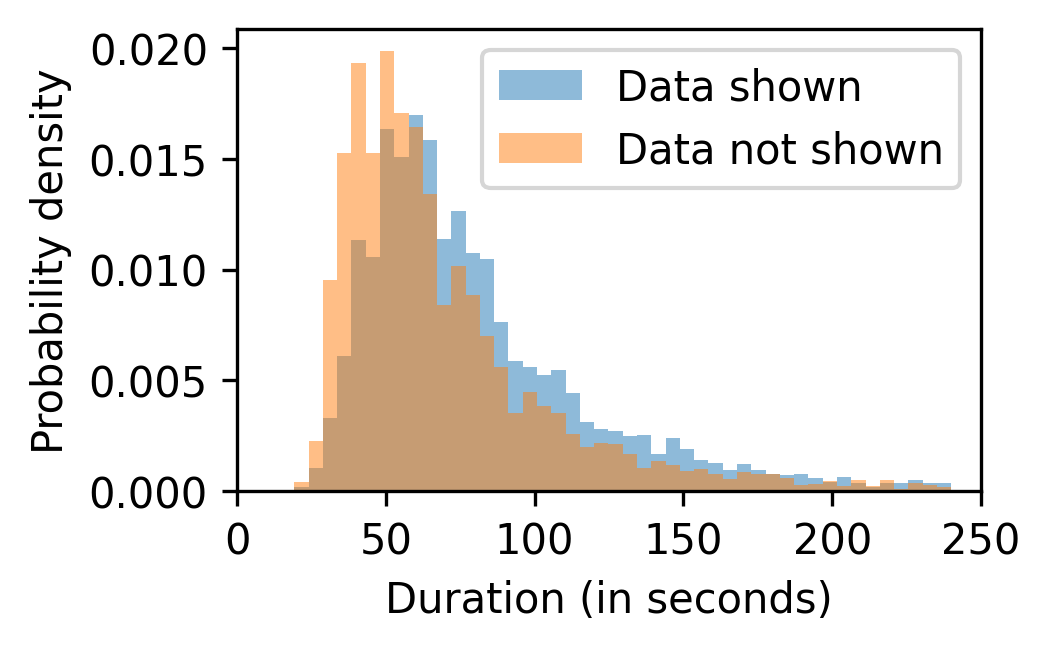

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3.2, 2), dpi=300)
_ = ax.hist(durations_showdata_true, bins=50, density=True, range=(0, 60*4), label='Data shown', alpha=0.5)
_ = ax.hist(durations_showdata_false, bins=50, density=True, range=(0, 60*4), label='Data not shown', alpha=0.5)
ax.set_xlim(0, 250)
ax.set_ylabel('Probability density')
ax.legend()
_ = ax.set_xlabel('Duration (in seconds)')

1-sided t-test:

Test the null hypothesis: The mean durations for the showdata:true and showdata:false groups are identical. We test this null hypothesis with a p-value of 0.05.

Alternative hypothesis: The mean duration for the showdata:true group is greater.


In [ ]:
ttest, pval = stats.ttest_ind(durations_showdata_true, durations_showdata_false, alternative='greater')
print("t-test statistic = %0.3f (p=%0.3f)" % (ttest, pval))
print("We reject the null hypothesis" if pval<0.05 else "we accept null hypothesis")

t-test statistic = 7.842 (p=0.000)
We reject the null hypothesis


Mann-Whitney U test: We also use a (non-parametric) Mann-Whitney U test because this data distribution is not normal.

In [ ]:
stat, pval = stats.mannwhitneyu(durations_showdata_true, durations_showdata_false, alternative='greater')
print("statistic = %0.3f (p=%0.3f)" % (stat, pval))
print("We reject the null hypothesis" if pval<0.05 else "we accept null hypothesis")

statistic = 23531056.500 (p=0.000)
We reject the null hypothesis


How different are these values?

Look at the difference in the means or medians?

In [ ]:
print('%0.2f seconds = mean duration for showdata:true' % durations_showdata_true.mean())
print('%0.2f seconds = mean duration for showdata:false' % durations_showdata_false.mean())
print(
    'The mean duration for showdata:true is %0.2fx than for showdata:false' % (
    durations_showdata_true.mean()/durations_showdata_false.mean())
)
print('%0.2f seconds = median duration for showdata:true' % durations_showdata_true.median())
print('%0.2f seconds = median duration for showdata:false' % durations_showdata_false.median())
print(
    'The median duration for showdata:true is %0.2fx than for showdata:false' % (
    durations_showdata_true.median()/durations_showdata_false.median())
)

95.27 seconds = mean duration for showdata:true
80.63 seconds = mean duration for showdata:false
The mean duration for showdata:true is 1.18x than for showdata:false
72.00 seconds = median duration for showdata:true
60.00 seconds = median duration for showdata:false
The median duration for showdata:true is 1.20x than for showdata:false


## Survey responses about privacy perceptions/concerns

Show the questions and do a quick tally of responses.

In [ ]:
# make an order for the responses
s_responses = [
    'Strongly disagree',
    'Somewhat disagree',
    'Neutral',
    'Somewhat agree',
    'Strongly agree'
]

Is this result much different when comparing participants who did vs did not share the browser data?

Make a table for each statement:

```
did share n, did not share n, overall n, overall %
```

In [ ]:
share_survey_df = survey_df[survey_df['share']==1]
no_share_survey_df = survey_df[survey_df['share']==0]

s1_df = (
    share_survey_df[S1].value_counts().reindex(s_responses).rename('Did share n').to_frame()
).merge(
    no_share_survey_df[S1].value_counts().reindex(s_responses).rename('Did not share n').to_frame(),
    how='inner', right_index=True, left_index=True
).merge(survey_df[S1].value_counts().reindex(s_responses).rename('Overall n').to_frame(),
    how='inner', right_index=True, left_index=True
)
s1_df['Overall %'] = round(100*s1_df['Overall n']/N, 1)
print('S1: %s' % fields_df.loc[S1]['Text'])
display(s1_df)

s2_df = (
    share_survey_df[S2].value_counts().reindex(s_responses).rename('Did share n').to_frame()
).merge(
    no_share_survey_df[S2].value_counts().reindex(s_responses).rename('Did not share n').to_frame(),
    how='inner', right_index=True, left_index=True
).merge(survey_df[S2].value_counts().reindex(s_responses).rename('Overall n').to_frame(),
    how='inner', right_index=True, left_index=True
)
s2_df['Overall %'] = round(100*s2_df['Overall n']/N, 1)
print('S2: %s' % fields_df.loc[S2]['Text'])
display(s2_df)

S1: “I think that I understand how browser fingerprinting works.”


,Did share n,Did not share n,Overall n,Overall %
Strongly disagree,1122,679,1801,14.5
Somewhat disagree,2211,1146,3357,26.9
Neutral,1300,634,1934,15.5
Somewhat agree,3218,1360,4578,36.7
Strongly agree,549,242,791,6.3


S2: “I am concerned that websites and companies try to fingerprint/track my browser.”


,Did share n,Did not share n,Overall n,Overall %
Strongly disagree,255,28,283,2.3
Somewhat disagree,992,109,1101,8.8
Neutral,1809,529,2338,18.8
Somewhat agree,3610,1847,5457,43.8
Strongly agree,1734,1548,3282,26.3


## Regression analysis

Set up for regression analysis.




#### How to code the responses to statements about privacy perceptions/concerns?


We code responses with 2 levels (boolean) indicating agreement or not.
- Neutral or disagree=0
- Agree=0


We might be tempted to code with multiple levels and use linear regression. e.g.
Code with 5 or 3 levels centered on neutral=0
- Strongly disagree= -2
- Somewhat disagree= -1
- Neutral=0
- Somewhat agree= 1
- Strongly agree=2

Code with 3 integers centered on neutral=0:
- Disagree= -1
- Neutral=0
- Agree=1


The reason we use binary coding and logistic regression here is that the responses are categorical and we cannot really know the meaning of an unobserved response value like 1.5.

After testing the impact of demographic variables, we do the following in order to simplify the regression analyses.

We:
- Do not include participants who answered "Other" in response to the question about their gender. This excludes 2% of participants.
- Aggregate race variables to the categories: "White", "Black", "Asian", "Other or mixed", where "Other or mixed" includes participants who selected "Other", "American Indian/Alaska Native", or multiple races.
- Do not include income groups in the regression. Note these variables had no significance in the response to statements about privacy perceptions/concerns.
- Do not include whether a participant is Hispanic. This variable had no significance in any of the regression results.


These changes are applied consistently to the regression analyzing participants likelihood to share as well as to the factors impacting their privacy perceptions/concerns.

For completeness, we repeat the regression analyses using all of the demographic attributes as they were collected.
These results are included in the SI.


In [ ]:
# set up the data for the regression

def get_s_agree(value):
    return 1 if (value in ['Strongly agree', 'Somewhat agree']) else 0

# limit to variables of interest
s_data = survey_df[[
    'showdata', 'share',
    'age', 'gender', 'income', 'hispanic', 'race',
]].copy()
s_data['s1'] = survey_df['Q-perceptions-1'].apply(get_s_agree)
s_data['s2'] = survey_df['Q-perceptions-2'].apply(get_s_agree)

print('Regression analysis data:')
display(s_data.head(3))

Regression analysis data:


,showdata,share,age,gender,income,hispanic,race,s1,s2
0,0,0,55 - 64 years,Female,Prefer not to say,0,Black,0,1
1,0,0,35 - 44 years,Male,"\$75,000 - \$99,999",0,Asian,1,1
2,1,1,45 - 54 years,Male,"\$75,000 - \$99,999",0,White,1,0


In [ ]:
# create a table representing the simplified demographic variables

age_reduced_map = {
    '18 - 24 years': '18 - 34 years',
    '25 - 34 years': '18 - 34 years',
    '35 - 44 years': '35 - 54 years',
    '45 - 54 years': '35 - 54 years',
    '55 - 64 years': '55 or older',
    '65 or older': '55 or older',
}
race_reduced_map = {
    'White': 'White',
    'Black': 'Black',
    'Asian': 'Asian',
    'American Indian/Alaska Native': 'Other or mixed',
    'Other or mixed': 'Other or mixed',
}
s_data_reduced = s_data[[
    'showdata', 'share',
    'age', 'gender', 'race',
    's1', 's2',
]].copy()
#s_data_reduced['age'] = s_data_reduced['age'].map(age_reduced_map)
s_data_reduced['race'] = s_data_reduced['race'].map(race_reduced_map)
s_data_reduced['gender'] = s_data_reduced['gender'].apply(lambda g: g if g in ['Female', 'Male'] else np.nan)
print('Reduced regression analysis data:')
s_data_reduced.head()

Reduced regression analysis data:


,showdata,share,age,gender,race,s1,s2
0,0,0,55 - 64 years,Female,Black,0,1
1,0,0,35 - 44 years,Male,Asian,1,1
2,1,1,45 - 54 years,Male,White,1,0
3,1,0,55 - 64 years,Female,Black,1,1
4,1,1,35 - 44 years,Male,White,0,1


In [ ]:
# Helper functions

# displaying / printing helpers
def get_stars(row):
    if row['p-value'] < 0.001:
        return '***'
    if row['p-value'] < 0.01:
        return '**'
    if row['p-value'] < 0.05:
        return '*'
    return ''

def get_predictors_table(model, p_05_stars=True):
    table = pd.DataFrame({
        'B (log odds)': model.params.apply(round, args=([3])),
        'Odds Ratio': np.exp(model.params).apply(round, args=([3])),
        '95% CI for Odds Ratio': (
            np.exp(model.conf_int())
            .apply(lambda r: '[%0.3f, %0.3f]'%(r[0], r[1]), axis=1)
        ),
        'p-value': model.pvalues.apply(round, args=([3]))
    }).rename_axis('Predictor')
    if p_05_stars:
        table['B (log odds)'] = table.apply(lambda r: '%s%s' % (r['B (log odds)'], get_stars(r)), axis=1)
    return table

### Regression analysis: Factors related to privacy perceptions/concerns

Which variables are most correlated with participants responses to the statements S1 and S1?

We test for this using regression analysis
where a positive coefficient corresponds to agreement with the statement

The reason we use logistic regression here is that the responses are categorical and we cannot really know the meaning of an unobserved response value like 1.5.

#### What to include in the regression?

(parentheses) indicate variables we considered but did not ultimately use.

S1 ~ intercept + gender + age + hispanic + race + income (+ showdata + share)

S2 ~ intercept + gender + age + hispanic + race + income + S1 + showdata + share

#### S1

In [ ]:
print('S1: %s' % fields_df.loc[S1]['Text'])

S1: “I think that I understand how browser fingerprinting works.”


In [ ]:
# Define and run the regression (reduced)
# intercept implicitly included
formula = 's1 ~ '
# formula += ' + showdata' # this has a negative coefficient. maybe showing data just confuses people
formula += ' + C(gender, Treatment(reference="Male"))'
formula += ' + C(age, Treatment(reference="35 - 44 years"))'
formula += ' + C(race, Treatment(reference="White"))'

print('Reduced regression analysis')
print('Formula:\n%s\n--------'%formula)
model = smf.logit(formula=formula, data=s_data_reduced).fit()
display(model.summary().tables[0])
display(get_predictors_table(model))

Reduced regression analysis
Formula:
s1 ~  + C(gender, Treatment(reference="Male")) + C(age, Treatment(reference="35 - 44 years")) + C(race, Treatment(reference="White"))
--------
Optimization terminated successfully.
         Current function value: 0.667216
         Iterations 4


Dep. Variable:,s1,No. Observations:,12210
Model:,Logit,Df Residuals:,12200
Method:,MLE,Df Model:,9
Date:,"Mon, 22 Jan 2024",Pseudo R-squ.:,0.02420
Time:,21:16:03,Log-Likelihood:,-8146.7
converged:,True,LL-Null:,-8348.8
Covariance Type:,nonrobust,LLR p-value:,1.812e-81


,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,0.121**,1.129,"[1.041, 1.225]",0.004
"C(gender, Treatment(reference=""Male""))[T.Female]",-0.664***,0.515,"[0.478, 0.554]",0.000
"C(age, Treatment(reference=""35 - 44 years""))[T.18 - 24 years]",-0.327***,0.721,"[0.636, 0.818]",0.000
"C(age, Treatment(reference=""35 - 44 years""))[T.25 - 34 years]",-0.153**,0.858,"[0.779, 0.945]",0.002
"C(age, Treatment(reference=""35 - 44 years""))[T.45 - 54 years]",0.073,1.076,"[0.955, 1.212]",0.230
"C(age, Treatment(reference=""35 - 44 years""))[T.55 - 64 years]",0.037,1.038,"[0.903, 1.192]",0.603
"C(age, Treatment(reference=""35 - 44 years""))[T.65 or older]",-0.256**,0.774,"[0.644, 0.930]",0.006
"C(race, Treatment(reference=""White""))[T.Asian]",-0.23**,0.794,"[0.697, 0.906]",0.001
"C(race, Treatment(reference=""White""))[T.Black]",0.281***,1.324,"[1.179, 1.487]",0.000


Observations:
- Males more often say they think they know how fingerprinting works
- Middle aged participants more likely to agree versus the younger and oldest (65+) groups of participants
- Asian less likely to agree, Black more likely to agree, when compared to White participants


In [ ]:
# Define and run the regression
# intercept implicitly included
formula = 's1 ~ '#share'
# formula += ' + showdata' # this has a negative coefficient. maybe showing data just confuses people?
formula += ' + C(gender, Treatment(reference="Male"))'
formula += ' + C(age, Treatment(reference="35 - 44 years"))'
formula += ' + C(income, Treatment(reference="\$50,000 - \$74,999"))'
formula += ' + C(race, Treatment(reference="White")) + hispanic'

print('Complete regression analysis')
print('Formula:\n%s\n--------'%formula)
model = smf.logit(formula=formula, data=s_data).fit()
display(model.summary().tables[0])
display(get_predictors_table(model))

Complete regression analysis
Formula:
s1 ~  + C(gender, Treatment(reference="Male")) + C(age, Treatment(reference="35 - 44 years")) + C(income, Treatment(reference="\$50,000 - \$74,999")) + C(race, Treatment(reference="White")) + hispanic
--------
Optimization terminated successfully.
         Current function value: 0.667039
         Iterations 4


Dep. Variable:,s1,No. Observations:,12461
Model:,Logit,Df Residuals:,12442
Method:,MLE,Df Model:,18
Date:,"Mon, 22 Jan 2024",Pseudo R-squ.:,0.02416
Time:,21:24:02,Log-Likelihood:,-8312.0
converged:,True,LL-Null:,-8517.8
Covariance Type:,nonrobust,LLR p-value:,3.396e-76


,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,0.133*,1.143,"[1.025, 1.274]",0.016
"C(gender, Treatment(reference=""Male""))[T.Female]",-0.662***,0.516,"[0.479, 0.555]",0.000
"C(gender, Treatment(reference=""Male""))[T.Other]",-0.395**,0.674,"[0.519, 0.875]",0.003
"C(age, Treatment(reference=""35 - 44 years""))[T.18 - 24 years]",-0.324***,0.723,"[0.638, 0.820]",0.000
"C(age, Treatment(reference=""35 - 44 years""))[T.25 - 34 years]",-0.146**,0.864,"[0.785, 0.952]",0.003
"C(age, Treatment(reference=""35 - 44 years""))[T.45 - 54 years]",0.082,1.085,"[0.963, 1.222]",0.178
"C(age, Treatment(reference=""35 - 44 years""))[T.55 - 64 years]",0.05,1.051,"[0.915, 1.208]",0.478
"C(age, Treatment(reference=""35 - 44 years""))[T.65 or older]",-0.241*,0.786,"[0.654, 0.945]",0.010
"C(income, Treatment(reference=""\$50,000 - \$74,999""))[T.Less than \$25,000]",-0.051,0.950,"[0.835, 1.082]",0.439


In [ ]:
print('S2: %s' % fields_df.loc[S2]['Text'])

S2: “I am concerned that websites and companies try to fingerprint/track my browser.”


In [ ]:
# Define and run the regression
# intercept implicitly included
formula = 's2 ~ share + showdata'
formula += ' + s1'
formula += ' + C(gender, Treatment(reference="Male"))'
formula += ' + C(age, Treatment(reference="35 - 44 years"))'
formula += ' + C(race, Treatment(reference="White"))'

print('Reduced regression analysis')
print('Formula:\n%s\n--------'%formula)
model = smf.logit(formula=formula, data=s_data_reduced).fit()
display(model.summary().tables[0])
display(get_predictors_table(model))

Reduced regression analysis
Formula:
s2 ~ share + showdata + s1 + C(gender, Treatment(reference="Male")) + C(age, Treatment(reference="35 - 44 years")) + C(race, Treatment(reference="White"))
--------
Optimization terminated successfully.
         Current function value: 0.573813
         Iterations 6


Dep. Variable:,s2,No. Observations:,12210
Model:,Logit,Df Residuals:,12197
Method:,MLE,Df Model:,12
Date:,"Mon, 22 Jan 2024",Pseudo R-squ.:,0.05948
Time:,21:27:50,Log-Likelihood:,-7006.3
converged:,True,LL-Null:,-7449.3
Covariance Type:,nonrobust,LLR p-value:,5.514e-182


,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.288***,3.626,"[3.185, 4.128]",0.000
"C(gender, Treatment(reference=""Male""))[T.Female]",0.012,1.012,"[0.932, 1.098]",0.779
"C(age, Treatment(reference=""35 - 44 years""))[T.18 - 24 years]",-0.22**,0.803,"[0.704, 0.916]",0.001
"C(age, Treatment(reference=""35 - 44 years""))[T.25 - 34 years]",0.004,1.004,"[0.903, 1.116]",0.941
"C(age, Treatment(reference=""35 - 44 years""))[T.45 - 54 years]",0.24**,1.272,"[1.111, 1.456]",0.001
"C(age, Treatment(reference=""35 - 44 years""))[T.55 - 64 years]",0.458***,1.582,"[1.342, 1.864]",0.000
"C(age, Treatment(reference=""35 - 44 years""))[T.65 or older]",0.527***,1.694,"[1.361, 2.108]",0.000
"C(race, Treatment(reference=""White""))[T.Asian]",0.35***,1.419,"[1.229, 1.639]",0.000
"C(race, Treatment(reference=""White""))[T.Black]",-0.025,0.975,"[0.858, 1.109]",0.700


#### S2

Observations:
- People who said they think they understand fingerprinting were more than 1.8x as likely to express concern with fingerprinting/tracking
- Sanity check: People who shared their data were less likely (0.33x as likely) to agree with this concern
- Showing people their browser attributes data did not have a significant impact on this concern
- Asians & "Other or mixed" races more likely than Whites to express concern
- The older people are, the more they tend to agree with this statement


In [ ]:
# Define and run the regression
# intercept implicitly included
formula = 's2 ~ share + showdata'
formula += ' + s1'
formula += ' + C(gender, Treatment(reference="Male"))'
formula += ' + C(age, Treatment(reference="35 - 44 years"))'
formula += ' + C(income, Treatment(reference="\$50,000 - \$74,999"))'
formula += ' + C(race, Treatment(reference="White")) + hispanic'

print('Complete regression analysis')
print('Formula:\n%s\n--------'%formula)
model = smf.logit(formula=formula, data=s_data).fit()
display(model.summary().tables[0])
display(get_predictors_table(model))

Complete regression analysis
Formula:
s2 ~ share + showdata + s1 + C(gender, Treatment(reference="Male")) + C(age, Treatment(reference="35 - 44 years")) + C(income, Treatment(reference="\$50,000 - \$74,999")) + C(race, Treatment(reference="White")) + hispanic
--------
Optimization terminated successfully.
         Current function value: 0.573132
         Iterations 6


Dep. Variable:,s2,No. Observations:,12461
Model:,Logit,Df Residuals:,12439
Method:,MLE,Df Model:,21
Date:,"Mon, 22 Jan 2024",Pseudo R-squ.:,0.06006
Time:,21:32:18,Log-Likelihood:,-7141.8
converged:,True,LL-Null:,-7598.1
Covariance Type:,nonrobust,LLR p-value:,1.104e-179


,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.296***,3.656,"[3.143, 4.253]",0.000
"C(gender, Treatment(reference=""Male""))[T.Female]",0.013,1.013,"[0.933, 1.100]",0.758
"C(gender, Treatment(reference=""Male""))[T.Other]",0.275,1.317,"[0.983, 1.765]",0.065
"C(age, Treatment(reference=""35 - 44 years""))[T.18 - 24 years]",-0.234**,0.792,"[0.694, 0.904]",0.001
"C(age, Treatment(reference=""35 - 44 years""))[T.25 - 34 years]",-0.002,0.998,"[0.898, 1.109]",0.967
"C(age, Treatment(reference=""35 - 44 years""))[T.45 - 54 years]",0.243***,1.275,"[1.114, 1.459]",0.000
"C(age, Treatment(reference=""35 - 44 years""))[T.55 - 64 years]",0.461***,1.586,"[1.346, 1.868]",0.000
"C(age, Treatment(reference=""35 - 44 years""))[T.65 or older]",0.523***,1.687,"[1.356, 2.099]",0.000
"C(income, Treatment(reference=""\$50,000 - \$74,999""))[T.Less than \$25,000]",0.028,1.029,"[0.892, 1.187]",0.699


### Sharing behavior

What impacts participants likelihood to share the browser attributes?

share ~ intercept + showdata + S1 + S2 + S1xS2 + gender + age + race + [hispanic + income + colleague]


In [ ]:
# Define and run the regression
# intercept implicitly included
formula = 'share ~ showdata'
formula += ' + C(gender, Treatment(reference="Male"))'
formula += ' + C(age, Treatment(reference="35 - 44 years"))'
formula += ' + C(race, Treatment(reference="White"))'
formula += ' + s1*s2' # Note: interacting with showdata (s1*s2*showdata) not significant

print('Reduced regression analysis')
print('Formula:\n%s\n--------'%formula)
model = smf.logit(formula=formula, data=s_data_reduced).fit()
display(model.summary().tables[0])
display(get_predictors_table(model))

Reduced regression analysis
Formula:
share ~ showdata + C(gender, Treatment(reference="Male")) + C(age, Treatment(reference="35 - 44 years")) + C(race, Treatment(reference="White")) + s1*s2
--------
Optimization terminated successfully.
         Current function value: 0.600363
         Iterations 6


Dep. Variable:,share,No. Observations:,12210
Model:,Logit,Df Residuals:,12196
Method:,MLE,Df Model:,13
Date:,"Mon, 22 Jan 2024",Pseudo R-squ.:,0.05014
Time:,22:18:46,Log-Likelihood:,-7330.4
converged:,True,LL-Null:,-7717.4
Covariance Type:,nonrobust,LLR p-value:,5.404e-157


,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.289***,3.629,"[3.174, 4.150]",0.000
"C(gender, Treatment(reference=""Male""))[T.Female]",-0.095*,0.909,"[0.840, 0.984]",0.019
"C(age, Treatment(reference=""35 - 44 years""))[T.18 - 24 years]",0.417***,1.517,"[1.319, 1.746]",0.000
"C(age, Treatment(reference=""35 - 44 years""))[T.25 - 34 years]",0.13*,1.139,"[1.026, 1.264]",0.015
"C(age, Treatment(reference=""35 - 44 years""))[T.45 - 54 years]",-0.041,0.959,"[0.845, 1.089]",0.520
"C(age, Treatment(reference=""35 - 44 years""))[T.55 - 64 years]",-0.119,0.888,"[0.768, 1.026]",0.107
"C(age, Treatment(reference=""35 - 44 years""))[T.65 or older]",-0.229*,0.795,"[0.660, 0.958]",0.016
"C(race, Treatment(reference=""White""))[T.Asian]",0.142*,1.152,"[1.001, 1.327]",0.049
"C(race, Treatment(reference=""White""))[T.Black]",-0.042,0.959,"[0.846, 1.087]",0.512


Observations:
- Showing data had an overall negative impact on share rates (odds ratio 0.87)
- Surprising: Participants who think they understand fingerprinting were more likely to share (odds ratio 2.6)
- Expected: participants who said they are are concerned with tracking less likely to share (odds ratio 0.41)
- Interesting: the interaction effect of the statement responses is negative. i.e. when participants both think they understand fingerprinting and are concerned about tracking, they were overall less likely to share (odds ratio 0.47).
- Note: interacting the statement responses with the showdata boolean did not yield significant effects

- Gender: Females slightly less likely to share (odds ratio 0.91)
- Age variation as expected: younger participants more likely to share; older less likely
- There were some differences by income: "Prefer not to say" less likely to share (consistent with not sharing income data); higher income more likely.
This may be related to unobserved variables, such as what motivates higher income people to participate in research on Prolific.
- Race: Asian participants slightly more likely to share (odds ratio 1.15)


Rerun the regression will all variables

In [ ]:
# Define and run the regression
# intercept implicitly included
formula = 'share ~ showdata'
formula += ' + C(gender, Treatment(reference="Male"))'
formula += ' + C(age, Treatment(reference="35 - 44 years"))'
formula += ' + C(income, Treatment(reference="\$50,000 - \$74,999"))'
formula += ' + C(race, Treatment(reference="White")) + hispanic'
formula += ' + s1*s2' # Note: interacting with showdata (s1*s2*showdata) not significant

print('Complete regression analysis')
print('Formula:\n%s\n--------'%formula)
model = smf.logit(formula=formula, data=s_data).fit()
display(model.summary().tables[0])
display(get_predictors_table(model))

Complete regression analysis
Formula:
share ~ showdata + C(gender, Treatment(reference="Male")) + C(age, Treatment(reference="35 - 44 years")) + C(income, Treatment(reference="\$50,000 - \$74,999")) + C(race, Treatment(reference="White")) + hispanic + s1*s2
--------
Optimization terminated successfully.
         Current function value: 0.598060
         Iterations 6


Dep. Variable:,share,No. Observations:,12461
Model:,Logit,Df Residuals:,12438
Method:,MLE,Df Model:,22
Date:,"Mon, 22 Jan 2024",Pseudo R-squ.:,0.05256
Time:,22:20:44,Log-Likelihood:,-7452.4
converged:,True,LL-Null:,-7865.8
Covariance Type:,nonrobust,LLR p-value:,1.201e-160


,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.216***,3.373,"[2.891, 3.934]",0.000
"C(gender, Treatment(reference=""Male""))[T.Female]",-0.089*,0.915,"[0.845, 0.991]",0.029
"C(gender, Treatment(reference=""Male""))[T.Other]",0.171,1.186,"[0.885, 1.590]",0.252
"C(age, Treatment(reference=""35 - 44 years""))[T.18 - 24 years]",0.43***,1.537,"[1.336, 1.768]",0.000
"C(age, Treatment(reference=""35 - 44 years""))[T.25 - 34 years]",0.131*,1.140,"[1.028, 1.266]",0.013
"C(age, Treatment(reference=""35 - 44 years""))[T.45 - 54 years]",-0.045,0.956,"[0.843, 1.085]",0.486
"C(age, Treatment(reference=""35 - 44 years""))[T.55 - 64 years]",-0.129,0.879,"[0.761, 1.016]",0.081
"C(age, Treatment(reference=""35 - 44 years""))[T.65 or older]",-0.238*,0.788,"[0.654, 0.950]",0.012
"C(income, Treatment(reference=""\$50,000 - \$74,999""))[T.Less than \$25,000]",0.107,1.113,"[0.969, 1.279]",0.130
